In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This notebook contains code to reproduce the following from Mitra, et al.:

**Main Figures:** 
* Figure 4A, B: Brainspan expression for case-only vs. ctrl-only genes
* Figure 4C: GTEx eSTRs p-values
* Figure 4D: HDAC2 example + population frequencies
* Figure 4E: HDAC2 eSTR Brain-Caudate
* Figure 4F: HDAC2 expression over time points

In [2]:
# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import statsmodels.api as sm
import seaborn as sns

# Color keys
colors = ['gray','red','gold','blue','green','purple','brown','salmon','magenta','cyan','darkblue']

# Other data paths
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation-rmdup.bed"
#AFREQFILE = "/storage/ileena/denovos5/parents_combined_all_phases_allele_freqs.separated.txt"
AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_allele_counts.tab"
HETFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_het.tab"
AGEFILE = "/storage/ileena/denovos4/metadata/ssc_4phases_ages.csv"
SFARIFILE = "/storage/mgymrek/ssc-denovos/annotations/SFARI-Gene_genes_08-29-2019release_09-11-2019export.csv"
JACKGENES = "/storage/mgymrek/ssc-denovos/annotations/jack_102genes.txt"
CONSTRAINTFILE="/storage/mgymrek/ssc-denovos/mutea/MUTEA_Constraint_hg38_GangSTR.bed"

# Output path info
OUTDIR = "pdfs/"

# Load expansions
ndata = pd.read_csv(NAIVEMUTFILE, sep="\t")
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)] # moderately big expansion events

# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")
usefams = set(alldata["family"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata])

# Manually remove problematic families. TODO add this instead to the QC script
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]
alldata = alldata[~alldata.family.isin(rmfams)]

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
alldata["chrom"] = alldata["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(alldata, annot, on=["chrom","pos"])

In [3]:
# Load expression data
coldata = pd.read_csv("/storage/resources/datasets/brainspan/RNA-Seq_Gencode_genes_matrix_csv/columns_metadata.csv")
rowdata = pd.read_csv("/storage/resources/datasets/brainspan/RNA-Seq_Gencode_genes_matrix_csv/rows_metadata.csv")
brainspan = pd.read_csv("/storage/resources/datasets/brainspan/RNA-Seq_Gencode_genes_matrix_csv/expression_matrix.csv",
                  names=coldata["column_num"])
brainspan.index = list(rowdata["gene_symbol"])

In [4]:
# Load per-locus mutation info
LOCFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.locus_stats.tab"
data = pd.read_csv(LOCFILE, delim_whitespace=True)

# Convert locus file to hg19
coords = pd.read_csv("/storage/mgymrek/ssc-denovos/for-gtex/ssc_hg19_coords.bed", sep="\t",
                     names=["chrom1","pos_hg19","end_hg19","coords_hg38"])
coords = coords[coords["chrom1"].apply(lambda x: "X" not in x and "Y" not in x and "_" not in x)]
coords["chrom"] = coords["chrom1"].apply(lambda x: GetChrom(x))
coords["pos"] = coords["coords_hg38"].apply(lambda x: int(x.split(":")[1]))
data = pd.merge(data, coords[["chrom","pos","pos_hg19"]], on=["chrom","pos"])

# Figure 4A: Expression of case-only vs. ctrl-only genes

In [5]:
# Get case-only and ctrl-only genes
def GetGene(x):
    if x["FEATURE-CODING"]>0: return x["gene-coding"]
    if x["FEATURE-UTR5"]>0: return x["gene-utr5"]
    if x["FEATURE-UTR3"]>0: return x["gene-utr3"]
    else: return x["TSS_GENE"]

usecols = (adata["FEATURE-PROMOTER5kb"]>0) | (adata["FEATURE-CODING"]>0) | (adata["FEATURE-UTR5"]>0) #| (adata["FEATURE-FETALBRAINTSS"]>0)
adata["gene"] = adata.apply(GetGene, 1)
genes_cases = set(adata[(adata["phenotype"]==2) & usecols]["gene"]).intersection(set(rowdata["gene_symbol"]))
genes_ctrls = set(adata[(adata["phenotype"]==1) & usecols]["gene"]).intersection(set(rowdata["gene_symbol"]))
both = genes_cases.intersection(genes_ctrls)
genes_cases = genes_cases.difference(both)
genes_ctrls = genes_ctrls.difference(both)

In [6]:
# Get expression for each

means_cases = []
means_ctrls = []
medians_cases = []
medians_ctrls = []
pvals = []

for i in range(1, (brainspan.shape[1])+1):
    cols = i
    mean_ctrl = np.mean(brainspan.loc[genes_ctrls,cols])
    mean_case = np.mean(brainspan.loc[genes_cases,cols])
    means_cases.append(mean_case)
    means_ctrls.append(mean_ctrl)
    median_ctrl = np.median(brainspan.loc[genes_ctrls,cols])
    median_case = np.median(brainspan.loc[genes_cases,cols])
    medians_cases.append(median_case)
    medians_ctrls.append(median_ctrl)
    expr_ctrl = np.log(brainspan.loc[genes_ctrls,cols]+0.01)
    expr_case = np.log(brainspan.loc[genes_cases,cols]+0.01)
    pvals.append(scipy.stats.ks_2samp(expr_ctrl, expr_case)[1])
    
coldata["mean_case"] = means_cases
coldata["mean_ctrl"] = means_ctrls
coldata["median_case"] = medians_cases
coldata["median_ctrl"] = medians_ctrls
coldata["pval"] = pvals

In [21]:
coldata.sort_values("pval")

,column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name,mean_case,mean_ctrl,median_case,median_ctrl,pval,FC
70,71,13060,H376.IIB.52,12 pcw,F,10269,V1C,"primary visual cortex (striate cortex, area V1...",12.078596,8.289491,4.340374,1.935637,0.001181,2.242349
16,17,12833,H376.IIA.50,9 pcw,M,10173,DFC,dorsolateral prefrontal cortex,11.844388,7.661844,4.978053,2.705198,0.001614,1.840181
77,78,12820,H376.IIIA.50,13 pcw,M,10361,AMY,amygdaloid complex,11.901243,8.299088,4.794433,2.445483,0.003282,1.960526
27,28,12833,H376.IIA.50,9 pcw,M,10552,CGE,caudal ganglionic eminence,11.219785,7.484490,4.231899,2.097935,0.003434,2.017174
22,23,12833,H376.IIA.50,9 pcw,M,10291,M1C-S1C,primary motor-sensory cortex (samples),11.504451,7.460074,4.776923,2.512596,0.003434,1.901190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,204,12288,H376.IV.50,24 pcw,M,10398,MD,mediodorsal nucleus of thalamus,12.465897,10.819611,3.160844,2.239039,0.216287,1.411697
8,9,13058,H376.IIA.51,8 pcw,M,10278,MFC,anterior (rostral) cingulate (medial prefronta...,11.587443,12.309209,3.838552,2.842087,0.224240,1.350610
356,357,12981,H376.IX.52,8 yrs,M,10278,MFC,anterior (rostral) cingulate (medial prefronta...,6.723638,7.667008,1.828530,1.333389,0.224240,1.371340
316,317,12836,H376.VIII.52,3 yrs,F,10236,A1C,primary auditory cortex (core),11.120904,12.353895,2.402269,2.102536,0.264785,1.142558


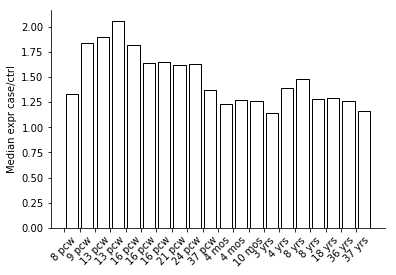

In [7]:
structure = "DFC"
coldata["FC"] = coldata.apply(lambda x: x["median_case"]/x["median_ctrl"], 1)
plotdata = coldata[(coldata["structure_acronym"]==structure) & (coldata["gender"]=="M")]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(plotdata.shape[0]), plotdata["FC"], color="white", edgecolor="black")
ax.set_xticks([item-0.5 for item in range(plotdata.shape[0])])
ax.set_xticklabels(plotdata["age"], rotation=45);
ax.set_ylabel("Median expr case/ctrl")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
fig.savefig(os.path.join(OUTDIR, "Figure4_Brainspan_%s.pdf"%structure))

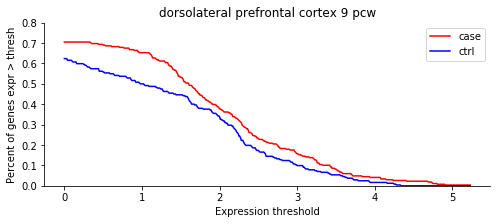

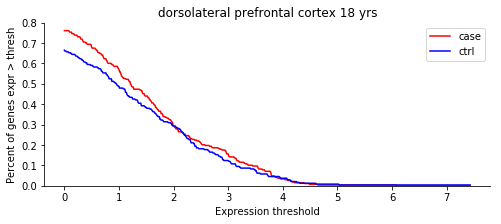

In [8]:
# Get cols for DFC, 3 time points
cols = list(coldata[(coldata["structure_acronym"]=="DFC") & (coldata["gender"]=="M") & 
                    (coldata["age"].apply(lambda x: x in ["9 pcw", "18 yrs"]))]["column_num"]) 

for col in cols:
    fig = plt.figure()
    fig.set_size_inches((8, 3))
    ax = fig.add_subplot(111)

    expr_cases = np.log(brainspan.loc[genes_cases, col]+0.01)
    expr_ctrls = np.log(brainspan.loc[genes_ctrls, col]+0.01)

    xvals = np.arange(0, max(max(expr_cases), max(expr_ctrls)), 0.01)
    ecdf_cases = []
    ecdf_ctrls = []
    for val in xvals:
        ecdf_cases.append(len([item for item in expr_cases if item >= val])*1.0/len(expr_cases))
        ecdf_ctrls.append(len([item for item in expr_ctrls if item >= val])*1.0/len(expr_ctrls))

    ax.plot(xvals, ecdf_cases, color="red", label="case")
    ax.plot(xvals, ecdf_ctrls, color="blue", label="ctrl")

    x = coldata[coldata["column_num"]==col]
    ax.set_title(x["structure_name"].values[0] + " " + x["age"].values[0])
    ax.set_xlabel("Expression threshold")
    ax.set_ylabel("Percent of genes expr > thresh")
    ax.set_ylim(bottom=0, top=0.8)
    ax.legend(loc="upper right")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    fig.savefig(os.path.join(OUTDIR, "Figure4_Brainspan_%s.pdf"%col))

# Figure 4C: GTEx QQ Plot

Adipose-Subcutaneous


/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


MannwhitneyuResult(statistic=6916689.0, pvalue=0.5599766627402993)
0.3355285465169736
3779
3668
Adipose-Visceral
MannwhitneyuResult(statistic=6810006.0, pvalue=0.5315747046442388)
0.34098235234152185
3754
3632
Artery-Aorta
MannwhitneyuResult(statistic=6877250.0, pvalue=0.06609515082824954)
0.438290249466215
3723
3621
Artery-Tibial
MannwhitneyuResult(statistic=6905214.0, pvalue=0.11480371244383147)
0.3315660684143576
3743
3631
Brain-Caudate
MannwhitneyuResult(statistic=6768328.0, pvalue=0.03864068998716572)
0.04563154414764396
3698
3575
Brain-Cerebellum
MannwhitneyuResult(statistic=6516052.0, pvalue=0.5055329268826749)
0.41518483019095137
3680
3542
Cells-Transformedfibroblasts
MannwhitneyuResult(statistic=6411703.0, pvalue=0.40942326823861985)
0.3515543974243835
3642
3510
Esophagus-Mucosa
MannwhitneyuResult(statistic=6877760.0, pvalue=0.28271058857800857)
0.22612179718741848
3749
3641
Esophagus-Muscularis
MannwhitneyuResult(statistic=6877622.0, pvalue=0.6733354997439137)
0.4783231759717

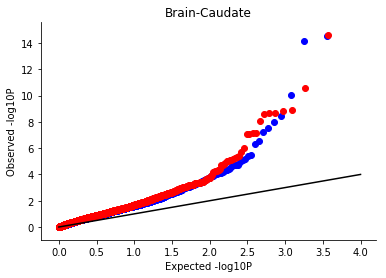

In [9]:
# Load gtex data
# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
def concat(x):
    return ",".join(x)

TISSUES=["Adipose-Subcutaneous",
         "Adipose-Visceral",
         "Artery-Aorta",
         "Artery-Tibial",
         "Brain-Caudate",
         "Brain-Cerebellum",
         "Cells-Transformedfibroblasts",
         "Esophagus-Mucosa",
         "Esophagus-Muscularis",
         "Heart-LeftVentricle",
         "Lung", 
         "Muscle-Skeletal", 
         "Nerve-Tibial",
         "Skin-NotSunExposed",
         "Skin-SunExposed", 
         "Thyroid",
         "WholeBlood"]

pvals = []

def GetXvals(size):
    # Get quantiles of uniform 0,1
    # return sorted -1*log10
    step = 1.0/size
    vals = np.array([step*(i+1) for i in range(size)])
    return -1*np.log10(vals)
    
for tissue in TISSUES:
    print(tissue)
    GTEXFILE = "/storage/mgymrek/gtex-estrs/revision/mastertables/%s_master.tab"%tissue
    gtex = pd.read_csv(GTEXFILE, sep="\t")
    gtex["chrom"] = gtex["chrom"].apply(lambda x: GetChrom(x))
    gtex["pos_hg19"] = gtex["str.start"].apply(int)
    gtex = gtex[~np.isnan(gtex["linreg.pval"])]
    gtex["linreg.beta"] = gtex["linreg.beta"].apply(abs)
    gtex = gtex.groupby(["chrom","pos_hg19","str.motif.forward"], as_index=False).agg({"linreg.pval": np.min, "linreg.beta": np.max, "gene.name": concat})

    merged = pd.merge(gtex, data, on=["chrom","pos_hg19"])
    #merged = merged[merged["str.motif.forward"].apply(len)>1]

    aff_pvals = -1*np.log10(sorted(list(merged[(merged["mut_aff"]>0) & (merged["mut_unaff"]==0)].sort_values("linreg.pval")["linreg.pval"])))
    unaff_pvals = -1*np.log10(sorted(list(merged[(merged["mut_unaff"]>0)& (merged["mut_aff"]==0)].sort_values("linreg.pval")["linreg.pval"])))

    print(scipy.stats.mannwhitneyu(aff_pvals, unaff_pvals, alternative="greater"))
    print(scipy.stats.ttest_ind(aff_pvals, unaff_pvals)[1]/2)
          
    print(len(aff_pvals))
    print(len(unaff_pvals))
    pvals.append(scipy.stats.mannwhitneyu(aff_pvals, unaff_pvals, alternative="greater")[1])
    if tissue == "Brain-Caudate":
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(GetXvals(len(unaff_pvals)), unaff_pvals, color="blue")
        ax.scatter(GetXvals(len(aff_pvals)), aff_pvals, color="red")
        ax.plot([0,4],[0,4], color="black")
        ax.set_title(tissue)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom');
        ax.set_xlabel("Expected -log10P")
        ax.set_ylabel("Observed -log10P")
        fig.savefig(os.path.join(OUTDIR, "Figure4_eSTR_QQ_%s.pdf"%tissue))

In [10]:
# Get HDAC2 info
GTEXFILE = "/storage/mgymrek/gtex-estrs/revision/mastertables/%s_master.tab"%"Brain-Caudate"
gtex = pd.read_csv(GTEXFILE, sep="\t")
gtex["chrom"] = gtex["chrom"].apply(lambda x: GetChrom(x))
gtex["pos_hg19"] = gtex["str.start"].apply(int)
merged = pd.merge(gtex, data, on=["chrom","pos_hg19"])

In [23]:
(merged[(merged["gene.name"]=="HDAC2") & (merged["pos"]==113970946)][["linreg.pval"]])

,linreg.pval
368,0.002003


# Figure 4E: HDAC allele freqs

In [12]:
AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_allele_counts.tab"
afreq = pd.read_csv(AFREQFILE, sep="\t")
afreq.columns = ["chrom","pos","newallele","count"]
afreq["chrom"] = afreq["chrom"].apply(GetChrom)

fdata = pd.merge(adata, afreq, on=["chrom","pos","newallele"], how="left")
fdata.ix[np.isnan(fdata["count"]),"count"] = 0

/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  import sys


In [13]:
adata[adata["pos"]==113970946][["child_gt","mat_gt","pat_gt"]]

,child_gt,mat_gt,pat_gt
146272,"5,8","8,8","8,8"


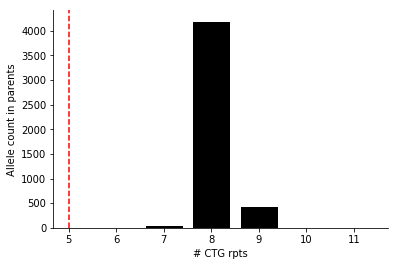

In [14]:
freqs = afreq[afreq["pos"]==113970946].copy()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(freqs["newallele"], freqs["count"], color="black", edgecolor="white");
ax.axvline(x=5, linestyle="dashed", color="red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.set_xlabel("# CTG rpts")
ax.set_ylabel("Allele count in parents")
fig.savefig(os.path.join(OUTDIR, "Figure4_HDAC2_AlleleCounts.pdf"))

# Figure 4D: HDAC2 eSTR

In [2]:
# Plot HDAC2 eSTR from GTEx
def ExtractData(gene, chrom, start, tissue, newdata=True):
    if "(" in tissue: tissue = tissue.split("(")[0]
    #vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    vcf = "/storage/mgymrek/ssc-denovos/for-gtex/Merged_STRs_all_samples.vcf.gz" # TODO remove
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom.replace("chr",""), start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    if newdata:
        expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Review_Rerun/%s/Corr_Expr.csv"%tissue
    else: expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    #expr = "/storage/mgymrek/ssc-denovos/for-gtex/Brain-Corr-Expr.csv" # TODO remove
    allgenes = open(expr,"r").readline().split(",")
    colnum = allgenes.index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)
    
def PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=None, newdata=True, period=None):
    ExtractData(gene, chrom, start, tissue, newdata=newdata)
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
        
    fig = plt.figure()
    fig.set_size_inches((8,5))
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr)
    #rmgts = []
    #for gt in sorted(list(set(data["str"]))):
    #    if data[data["str"]==gt].shape[0] <3: rmgts.append(gt)
    #data = data[data["str"].apply(lambda x: x not in rmgts)]
    boxcol = "gray"
    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color="black", zorder=0)
    sns.boxplot(x="str", y="expr", ax=ax, data=data, color="white", linewidth=0.5, 
                boxprops={'facecolor':'None', 'edgecolor': boxcol}, showfliers=False)
    # Set box properties
    for i,artist in enumerate(ax.artists):
        artist.set_edgecolor(boxcol)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        x = 5
        for j in range(i*x,i*x+x):
            line = ax.lines[j]
            line.set_color(boxcol)
            line.set_mfc(boxcol)
            line.set_mec(boxcol)
    totals = data.groupby("str", as_index = False).agg({"expr": len})
    print(totals.sort_values("str"))
    means = data.groupby("str", as_index = False).agg({"expr": np.mean})
    means = means.sort_values("str")
    means["num"] = range(means.shape[0])
    
    ax.plot(means["num"], means["expr"], color="red", marker="o", linewidth=2)
    ax.set_xlabel("Mean num. rpts.", size=15)
    ax.set_ylabel("Normalized Expression - %s"%tissue, size=15)
    ax.set_xticklabels(["%.1f"%((item*0.5+reflen)/period) for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.1f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title("%s %s %s"%(chrom, start,gene))
    plt.suptitle("");
    plt.show()
    if fname is not None: fig.savefig(fname)
        
# HDAC2
chrom = "chr6"
start = 114292110
end = 114292110
gene = "ENSG00000196591.7"
tissue = "Brain-Caudate"
period = 3
offset = 0
reflen = (end+1+offset-start)
fname = os.path.join(OUTDIR, "Figure4_HDAC2_eSTR.pdf")
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

NameError: name 'os' is not defined

# Figure 4F: HDAC2 expression over time points

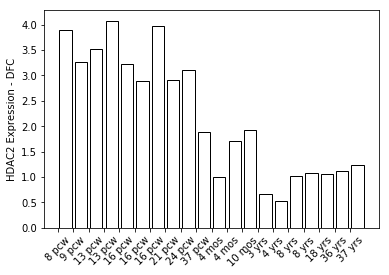

In [16]:
structure = "DFC"
plotdata = coldata[(coldata["structure_acronym"]==structure) & (coldata["gender"]=="M")].copy()
cols = list(plotdata["column_num"])
plotdata["HDAC2"] = list(np.log(brainspan.loc["HDAC2", cols]+0.01))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(plotdata.shape[0]), plotdata["HDAC2"], color="white", edgecolor="black")
ax.set_xticks([item-0.5 for item in range(plotdata.shape[0])])
ax.set_xticklabels(plotdata["age"], rotation=45);
ax.set_ylabel("HDAC2 Expression - %s"%structure)
fig.savefig(os.path.join(OUTDIR, "Figure4_HDAC2_%s.pdf"%structure))

# Examples for supp fig
Novel allele proband, in promoter/UTR5/coding
12 in probands, 7 in siblings
for each, show: pedigree, allele freq distribution, gene diagram
(4x3) for probands, (4x2) for siblings

In [19]:
fdata[(fdata["phenotype"]==1) & (fdata["count"]==0) & 
      ((fdata["FEATURE-CODING"]>0) | (fdata["FEATURE-UTR5"]>0 | (fdata["FEATURE-PROMOTER5kb"]>0)))].sort_values("mutsize", ascending=False)[["chrom","pos","newallele","child_gt","mat_gt","pat_gt","gene-coding","TSS_GENE"]]

,chrom,pos,newallele,child_gt,mat_gt,pat_gt,gene-coding,TSS_GENE
164753,6,1611317,12,"4,12","4,4","4,4",FOXC1,FOXC1
69682,17,2057111,11,"8,11","8,8","8,8",HIC1,HIC1
149617,6,108561085,6,"5,6","5,5","5,5",0,FOXO3
101000,11,76860956,5,"5,6","6,6","6,6",0,ACER3
128505,7,157005635,2,"2,3","3,3","3,3",MNX1,MNX1-AS2
138789,10,356496,1,"1,2","2,2","2,2",DIP2C,DIP2C
160506,16,27219017,3,"3,4","4,4","4,4",KDM8,KDM8


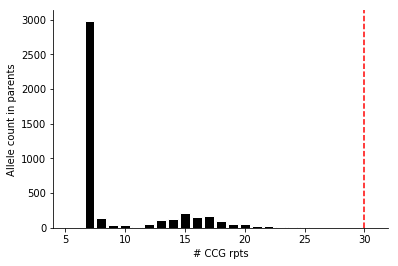

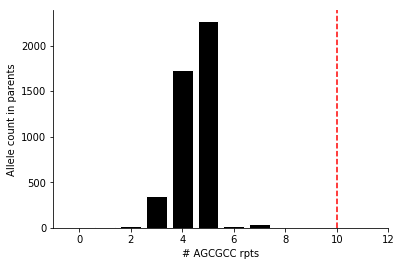

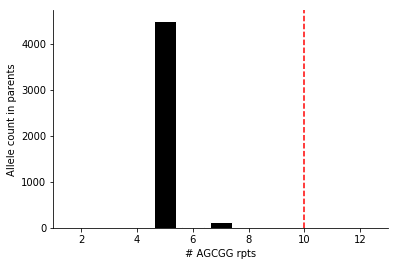

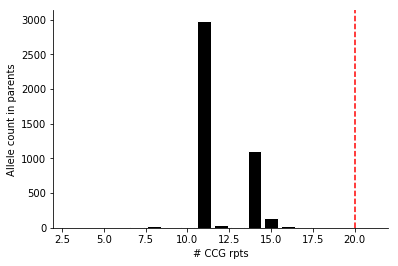

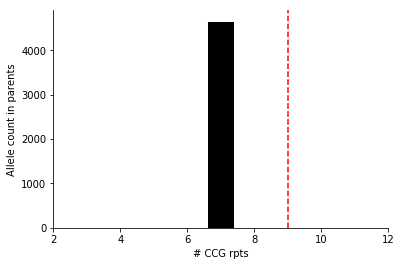

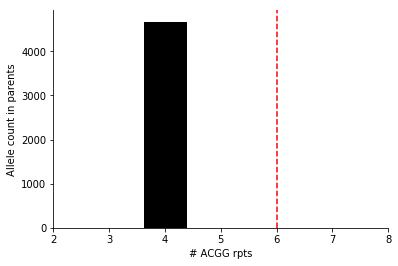

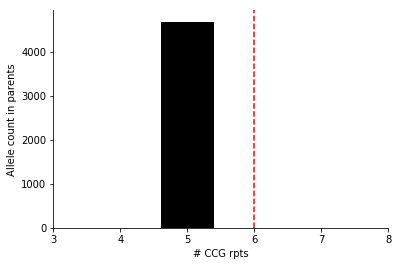

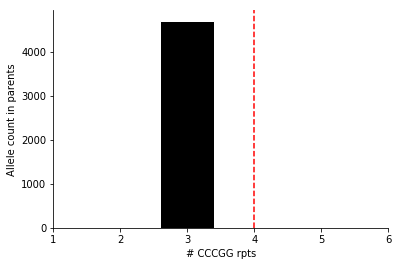

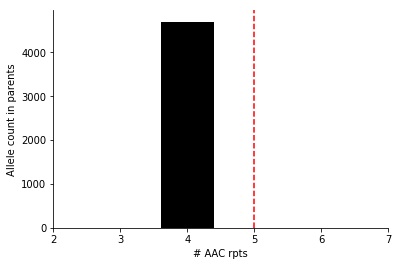

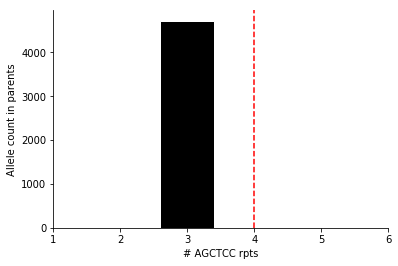

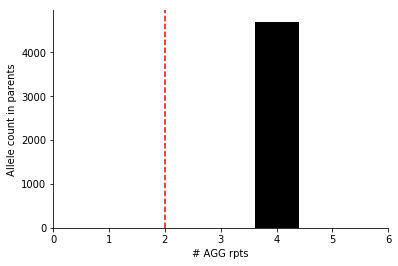

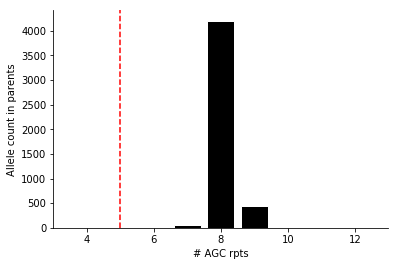

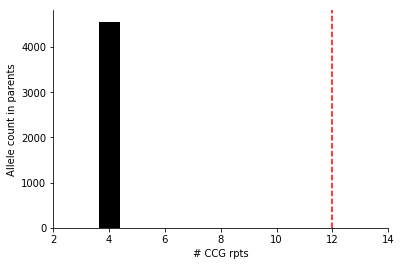

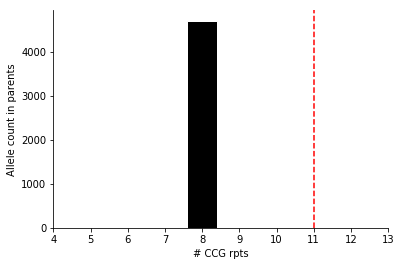

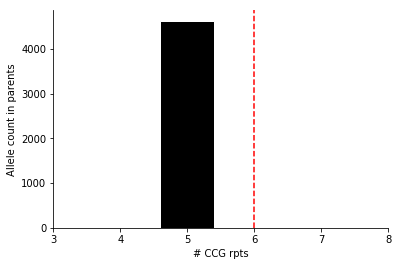

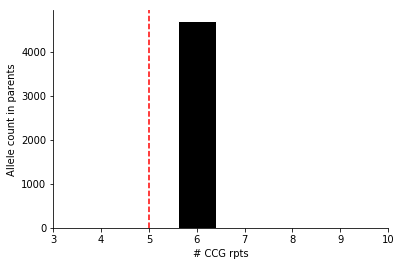

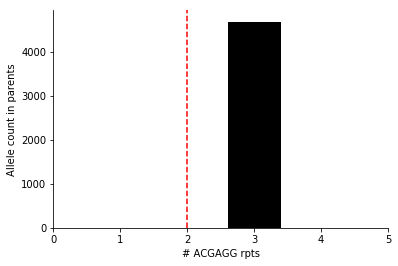

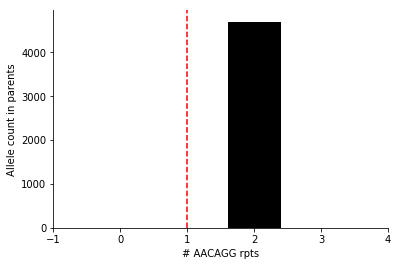

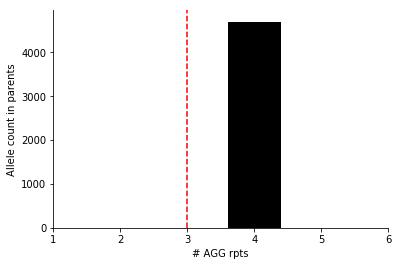

In [18]:
proband_pos = fdata[(fdata["phenotype"]==2) & (fdata["count"]==0) & 
      ((fdata["FEATURE-CODING"]>0) | (fdata["FEATURE-UTR5"]>0 | (fdata["FEATURE-PROMOTER5kb"]>0)))].sort_values("mutsize", ascending=False)["pos"]
sibling_pos = fdata[(fdata["phenotype"]==1) & (fdata["count"]==0) & 
      ((fdata["FEATURE-CODING"]>0) | (fdata["FEATURE-UTR5"]>0 | (fdata["FEATURE-PROMOTER5kb"]>0)))].sort_values("mutsize", ascending=False)["pos"]

for pos in list(proband_pos)+list(sibling_pos):
    freqs = afreq[afreq["pos"]==pos].copy()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(freqs["newallele"], freqs["count"], color="black", edgecolor="white");
    newallele = fdata[(fdata["pos"]==pos) & (fdata["count"]==0)]["newallele"].values[0]
    motif = fdata[(fdata["pos"]==pos)]["motif"].values[0]
    ax.axvline(x=newallele, linestyle="dashed", color="red")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xlabel("# %s rpts"%motif)
    ax.set_ylabel("Allele count in parents")
    minallele = min([newallele]+list(freqs["newallele"]))
    maxallele = max([newallele]+list(freqs["newallele"]))
    ax.set_xlim(left=minallele-2, right=maxallele+2)
    if pos in list(proband_pos): name = "proband"
    else: name = "sibling"
    fig.savefig(os.path.join(OUTDIR, "SuppFig_%s_%s_AlleleCounts.pdf"%(pos, name)))